### Dependencies I had to install:

!pip install livelossplot

!pip install librosa

In [1]:
import random, os, glob # default python modules that let me randomise and manipulate files
import numpy as np # for data manipulation through arrays
import tensorflow as tf
from keras.models import Sequential # the model I will use
from keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten, Reshape, BatchNormalization, GlobalAveragePooling2D # layers I will incorporate
from keras.callbacks import EarlyStopping # for better training
from tensorflow.keras.applications import VGG19 # transfer learning model
from keras import backend
from livelossplot import PlotLossesKeras # to visualy display how my model improves as training progresses
import librosa # to demonstrate the creation of a mel spectrogram
from librosa.display import specshow
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def setRandom():
    seed = 0 # random seed value
    os.environ["PYTHONHASHSEED"] = str(seed) # if this is not set, a random value is used to seed the hashes of some objects
    random.seed(seed) # sets the base python and numpy random seeds
    np.random.seed(seed)
    tf.random.set_seed(seed) # sets the tensorflow random seed
    tf.compat.v1.set_random_seed(seed)

### Example Code of How to Make a Spectogram:

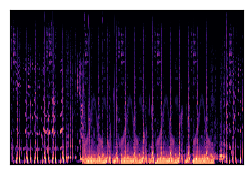

In [3]:
filePath = "../data/genres_original/hiphop/hiphop.00009.wav" # an example file

file, samplingRate = librosa.load(filePath)
example, _ = librosa.effects.trim(file)

hopLength = 512 # the number of samples between successive columns of the spectrogram

spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y = example, sr = samplingRate, n_fft = 2048, hop_length = hopLength, n_mels = 128, power = 4.0), ref = np.max)

plt.figure(figsize = (3, 2))
librosa.display.specshow(spectrogram, sr = samplingRate, hop_length = hopLength, x_axis = "off", y_axis = "off")
ipd.Audio(example, rate = samplingRate)

### Preparing Data

In [3]:
source = "../data/images_original/" # source folder path
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"] # list with the genre folder names

for genre in genres: # iterate through each genre folder
    path = os.path.join(source, genre)
    pngs = [i for i in os.listdir(path) if i[-4:] == ".png"] # get a list of .png files in the genre folder
    print(f"Size of {genre} dataset: {len(pngs)} files.")

Size of blues dataset: 100 files.
Size of classical dataset: 100 files.
Size of country dataset: 100 files.
Size of disco dataset: 100 files.
Size of hiphop dataset: 100 files.
Size of jazz dataset: 99 files.
Size of metal dataset: 100 files.
Size of pop dataset: 100 files.
Size of reggae dataset: 100 files.
Size of rock dataset: 100 files.


### Splitting Data

In [9]:
setRandom()
split = [80, 20]
train, test = {}, {} # empty dictionaries to store the filepaths
trainLen, testLen = {}, {} # empty dictionaries to store the number of files under each genre for each dataset
dictionaries = [train, test]

for d in dictionaries:
    if d == train: num = slice(0, split[0])
    else: num = slice(split[0], split[0] + split[1])
    for genre in genres: # iterate through each genre folder
        path = os.path.join(source, genre)
        pngs = glob.glob(os.path.join(path, "*.png")) # get a list of .png filepaths in the genre folder
        selected = pngs[num] # take the first 80 files
        d[genre] = selected # store the selected files in the dictionary

lenDictionaries = [{genre: len(d[genre]) for genre in genres} for d in dictionaries]        

print(f"\033[1mTraining:\033[0m {lenDictionaries[0]}")
print(f"\033[1mTest:\033[0m {lenDictionaries[1]}")

Training: {'blues': 80, 'classical': 80, 'country': 80, 'disco': 80, 'hiphop': 80, 'jazz': 80, 'metal': 80, 'pop': 80, 'reggae': 80, 'rock': 80}
Test: {'blues': 20, 'classical': 20, 'country': 20, 'disco': 20, 'hiphop': 20, 'jazz': 19, 'metal': 20, 'pop': 20, 'reggae': 20, 'rock': 20}


### Data Formatting

In [10]:
batchSize = 32 # typical batch size for a neural network
genreMap = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9
}
inverseGenreMap = {value: key for key, value in genreMap.items()}

def createDataset(d):
    imgSize = (288, 432) # define image and batch parameters
    imageList, labelList = [], [] # create lists to store images and labels
    
    for genre, paths in d.items():
        for path in paths:
            image = tf.cast(tf.image.resize(tf.image.decode_png(tf.io.read_file(path), channels = 3), imgSize), tf.float32) / 255.0 # normalise pixel values between 0 and 1 (preprocessing!)
            imageList.append(image)
            labelList.append(genreMap[genre]) # convert genre to its integer label

    dataset = tf.data.Dataset.from_tensor_slices((imageList, labelList)).shuffle(buffer_size=len(imageList)).batch(batchSize) # create and return tensorflow dataset
    return(dataset)

def prep(ds):
    out = (
        ds.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)) # modifies the image tensor's data type to floats
        .cache() # cache dataset elements in memory or on disk to speed up data loading
        .prefetch(buffer_size = tf.data.experimental.AUTOTUNE) # prefetch dataset elements in the background and automatically optimise data loading
    )
    return out # return the prepared and optimised dataset

training, testing = prep(createDataset(train)), prep(createDataset(test))
print("Datasets created.") # to let me know when it's finished running (:

Datasets created.


### Training the Model

In [11]:
inputShape = [288, 432, 3] # the shape of the images (288px tall, 432px wide, and 3 colour channels/RGB)

earlyStopping = EarlyStopping( # a custom early stopping setup to automatically stop training when loss doesn't increase enough after a number of epochs
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 20, # how many epochs to wait before stopping
    restore_best_weights = True # tells it to restore back to when loss was at its lowest value
)

In [12]:
cnn = Sequential([
    BatchNormalization(input_shape = inputShape),

    Conv2D(32, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(64, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),
    
    Conv2D(128, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),
    
    Conv2D(256, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),
    
    Conv2D(512, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),
    Flatten(),
    
    Dense(1024, activation = "relu"),
    Dropout(0.5),
    Dense(512, activation = "relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(genres), activation = "softmax")
])

cnn.compile(optimizer = tf.keras.optimizers.SGD(lr = 0.001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) # "sparse_categorical_crossentropy" because labels are integers
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 288, 432, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 286, 430, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 143, 215, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 70, 106, 64)       0         
 g2D)                                                            
                                                        

In [ ]:
setRandom()
cnn.fit(training, validation_data = testing, batch_size = batchSize,
         epochs = 500, verbose = 1, callbacks = [earlyStopping, PlotLossesKeras()])